#Where will a new guest book their first travel experience?

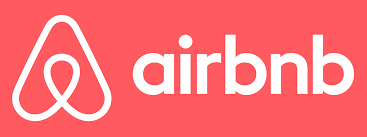

In [1]:
from IPython.display import Image
Image('airbnb.png', width=400)

##Introduction

In this [competition](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings) Airbnb challenged Kagglers to predict in which country a new user will make his or her first booking. 
The below implementation is the result of the team work with [Gabriele Lanaro](http://gabrielelanaro.github.io/). Both of us actively contributed to code, technical discussions and finding solutions to blockers along the road.
The final pipeline consists of the following steps:
1. Reading and preprocessing the available data (including user sessions).
2. Using a Random Forest classifier to identify negligible features. Specifically we decided to remove all the features having less than 0.1% of relative importance.
3. Running Cross Validation to select best classifier/hyperparameters. This step pointed us in the direction of the Bagging algorithm. 
4. Due to technical restrictions in our infrastructure (limitations in RAM and computational power) we ran 5 separate Bagging Classifiers on the final dataset and averaged the results to come up with a definitive outcome.
5. Generating the submission file on top of the previous model.

####Getting Train and Test set and outputting a data set ready to be fed into a Machine Learning pipeline

In [2]:
def make_user_features(train, test):
    #encoding country destinations in train set
    outcome = train.country_destination
    labels = outcome.values
    le = LabelEncoder()
    y = le.fit_transform(labels)
    train = train.drop(['country_destination'], axis=1)

    #storing user ids in test set
    id_test = test['id']

    #appending test to train and dropping date first booking which is redundant
    data = pd.concat((train, test), axis=0, ignore_index=True)
    data = data.drop(['date_first_booking'], axis=1)

    #extracting features from date_account_created
    data['dac_year'] = data.date_account_created.apply(lambda x: x.year)
    data['dac_month'] = data.date_account_created.apply(lambda x: x.month)
    data['dac_weekday'] = data.date_account_created.apply(lambda x: x.weekday())
    data = data.drop(['date_account_created'], axis=1)

    #extracting features from timestamp_first_active
    data['tfa_year'] = data.timestamp_first_active.apply(lambda x: x.year)
    data['tfa_month'] = data.timestamp_first_active.apply(lambda x: x.month)
    data['tfa_weekday'] = data.timestamp_first_active.apply(lambda x: x.weekday())
    data = data.drop(['timestamp_first_active'], axis=1)

    #filling age nan with age median
    data.age = data.age.fillna(data.age.median())

    #binning age column
    bins = list(np.arange(15, 85, 5))
    bins.insert(0,0)
    bins.append(int(max(data.age)))
    group_names = ['<15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50',
                   '50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '>80']
    data['age_bucket'] = pd.cut(data['age'], bins, labels=group_names)

    #cleaning gender column and filling nan in all dataframe with 'unknown'
    data.gender = data.gender.replace('-unknown-','unknown')
    data.ix[:, data.columns != 'age_bucket'] = data.ix[:, data.columns != 'age_bucket'].fillna('unknown')

    #generating dummy variables in top of categorical columns
    to_be_dummified = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', 
                       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
                       'first_device_type', 'first_browser','age_bucket']
    for f in to_be_dummified:
        dummies = pd.get_dummies(data[f], prefix=f)
        data = data.drop([f], axis=1)
        data = pd.concat((data, dummies), axis=1)

    return data[:train.shape[0]], data[train.shape[0]:], y, le

####Adding Sessions to the previously generated User data set

In [8]:
def make_sessions_features(data, df_sessions):
    # Drop row with nan values from the "user_id" column as they're useless
    df_sessions = df_sessions.dropna(subset=["user_id"])

    # print df_sessions

    # Frequency of devices - by user
    device_freq = df_sessions.groupby('user_id').device_type.value_counts()
    
    # Frequency of actions taken - by user
    action_freq = df_sessions.groupby('user_id').action.value_counts()

    # Total list of users
    users = data.id.values
    def feature_dict(df):
        f_dict = dict(list(df.groupby(level='user_id')))
        res = {}
        for k, v in f_dict.items():
            v.index = v.index.droplevel('user_id')
            res[k] = v.to_dict()
        return res

    # Make a dictionary with the frequencies { 'user_id' : {"IPhone": 2, "Windows": 1}}
    action_dict = feature_dict(action_freq)
    device_dict = feature_dict(device_freq)

    # Transform to a list of dictionaries
    action_rows = [action_dict.get(k, {}) for k in users]
    device_rows = [device_dict.get(k, {}) for k in users]

    device_transf = DictVectorizer()
    tf = device_transf.fit_transform(device_rows)

    action_transf = DictVectorizer()
    tf2 = action_transf.fit_transform(action_rows)

    # Concatenate the two datasets
    # Those are row vectors with the frequencies of both device and actions [0, 0, 0, 2, 0, 1, ...]
    features = sp.hstack([tf, tf2])

    # We create a dataframe with the new features and we write it to disk
    df_sess_features = pd.DataFrame(features.todense())
    
    df_sess_features['id'] = users

    #left joining data and sessions on user_id
    final = pd.merge(data, df_sess_features, how='left', left_on='id', right_on='id')
    final.ix[:, final.columns != 'age_bucket'].fillna(-1, inplace=True)

    final.drop(['id'], axis=1, inplace=True)
    return final

####Putting together the competition specific evaluation metrics,  NDCG (Normalized discounted cumulative gain) @k where k=5. 

In [9]:
""" Reference from https://gist.github.com/bwhite/3726239
"""

import numpy as np

def mean_ndcg(clf, X, y):
    # Predict class probabilities
    y_predict = clf.predict_proba(X)
    # Get highest 5 predictions
    best_5 = np.argsort(-y_predict, axis=1)[:, :5]

    # Transform to relevance scores
    relevance = (best_5 == y[:, np.newaxis]).astype('int')

    # Calculate ndcg for each sample and take average (?)
    return np.mean([ndcg_at_k(row, 5) for row in relevance])

def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

####Function to generate submission files for Kaggle

In [10]:
def generate_submission(y_pred, id_test, le, filename):
    ids = []  #list of ids
    cts = []  #list of countries
    for i in range(len(id_test)):
        idx = id_test[i]
        ids += [idx] * 5
        cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

    #Generate submission
    sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
    sub.to_csv(os.path.join('data', filename),index=False)
    print 'Submission File Successfully Generated'

##Machine Learning Pipeline

In [3]:
#importing packages
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
import scipy.sparse as sp

####Reading and preprocessing data

In [4]:
#reading data
pretest = pd.read_csv(os.path.join('data', 'test_users.csv'), header=0, parse_dates=[1,2,3])
pretrain = pd.read_csv(os.path.join('data', 'train_users_2.csv'), header=0, parse_dates=[1,2,3])
df_sessions = pd.read_csv("data/sessions.csv", encoding='utf8')

In [5]:
pretrain.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
train, test, y, le = make_user_features(pretrain, pretest)

In [11]:
data = pd.concat((train, test), axis=0, ignore_index=True)
final = make_sessions_features(data, df_sessions)

del data

In [12]:
X_train = final.ix[:train.shape[0]-1]
X_test = final.ix[train.shape[0]:]

In [13]:
assert train.shape[0] == y.shape[0]

In [14]:
assert X_train.shape[0] == train.shape[0]
assert X_train.shape[0] == y.shape[0]
print 'Train Set shape:', X_train.shape
print 'Test Set shape:', X_test.shape
print 'Labels shape:', y.shape

Train Set shape: (213451, 549)
Test Set shape: (62096, 549)
Labels shape: (213451L,)


In [15]:
del final

####Selecting irrelevant features via a Random Forest Classifier

In [16]:
#fitting a Random Forest Classifier to select negligible features
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=160, oob_score=True, n_jobs=-1, criterion='entropy')
clf.fit(X_train, y)
print 'Number of features to be discarded: ', np.count_nonzero(clf.feature_importances_ < 1e-4)

Number of features to be discarded:  311


In [17]:
#getting uninportant features
unimportant_features = clf.feature_importances_ < 1e-4

####Selecting best model/hyperparameters via Cross Validation

In [18]:
#Splitting Train set into Train and Test again to perform CV
#The classification task is very challenging due to the data being extremely skewed.
#Hence, we make sure to stratify our samples as almost 95% of them are covered by 3 classes only: NDF, US, OTHER. 
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
from sklearn.grid_search import GridSearchCV
from pprint import pprint

sub_X_train, sub_X_test, sub_y_train, sub_y_test = train_test_split(X_train, y, test_size=0.33, random_state=42, stratify=y)

###Bagging

In [18]:
from sklearn.ensemble import BaggingClassifier
bagg = BaggingClassifier(random_state=42)

param_grid = {"n_estimators": [10, 50, 100],
              "max_samples": [0.1, 0.5, 1.0],
              "max_features": [0.1, 0.5, 1.0]}

baggsearch = GridSearchCV(bagg, param_grid, scoring='f1_weighted', cv=3, verbose=4, n_jobs=-1)
baggsearch.fit(sub_X_train, sub_y_train)

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 62.5min finished


Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, error_score='raise',
       estimator=BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
         verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 50, 100], 'max_samples': [0.1, 0.5, 1.0], 'max_features': [0.1, 0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_weighted',
       verbose=4)

####Bagging Classifier: Results of Search Grid CV (evaluation metrics: F1 Weighted Score)

In [19]:
pprint(sorted(baggsearch.grid_scores_, key=lambda x: -x.mean_validation_score))

[mean: 0.59403, std: 0.00169, params: {'max_features': 1.0, 'max_samples': 0.1, 'n_estimators': 100},
 mean: 0.58978, std: 0.00201, params: {'max_features': 1.0, 'max_samples': 0.1, 'n_estimators': 50},
 mean: 0.58491, std: 0.00053, params: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100},
 mean: 0.58245, std: 0.00059, params: {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50},
 mean: 0.58213, std: 0.00056, params: {'max_features': 0.5, 'max_samples': 0.1, 'n_estimators': 100},
 mean: 0.58174, std: 0.00056, params: {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100},
 mean: 0.58031, std: 0.00087, params: {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100},
 mean: 0.57837, std: 0.00108, params: {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50},
 mean: 0.57829, std: 0.00091, params: {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 50},
 mean: 0.57760, std: 0.00127, params: {'max_features': 0.5, 'max_samples': 0.1, 'n_est

In [20]:
print 'NDCG on Test Set', mean_ndcg(baggsearch.best_estimator_, sub_X_test, sub_y_test)
print 'F1 Weighted Score on Test Set', f1_score(sub_y_test, baggsearch.best_estimator_.predict(sub_X_test), average='weighted')  

NDCG on Test Set 0.914233699603
F1 Weighted Score on Test Set 0.594105356053


C:\Users\pochetti\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


###KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)

param_grid = {"n_neighbors": [1, 2, 4, 8, 16]}

knnsearch = GridSearchCV(neigh, param_grid, scoring='f1_weighted', cv=3, verbose=4, n_jobs=1)
knnsearch.fit(sub_X_train, sub_y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] n_neighbors=1 ...................................................
[CV] .......................... n_neighbors=1, score=0.495831 -21.6min
[CV] n_neighbors=1 ...................................................
[CV] .......................... n_neighbors=1, score=0.498015 -22.2min
[CV] n_neighbors=1 ...................................................
[CV] .......................... n_neighbors=1, score=0.497071 -20.3min
[CV] n_neighbors=2 ...................................................
[CV] .......................... n_neighbors=2, score=0.491657 -23.1min
[CV] n_neighbors=2 ...................................................
[CV] .......................... n_neighbors=2, score=0.490935 -24.1min
[CV] n_neighbors=2 ...................................................
[CV] .......................... n_neighbors=2, score=0.489456 -23.1min
[CV] n_neighbors=4 ...................................................
[CV] ............

C:\Users\pochetti\AppData\Local\Continuum\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 363.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 4, 8, 16]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_weighted',
       verbose=4)

####KNN Classifier: Results of Search Grid CV (evaluation metrics: F1 Weighted Score)

In [20]:
pprint(sorted(knnsearch.grid_scores_, key=lambda x: -x.mean_validation_score))

[mean: 0.54188, std: 0.00110, params: {'n_neighbors': 16},
 mean: 0.53778, std: 0.00177, params: {'n_neighbors': 8},
 mean: 0.52777, std: 0.00119, params: {'n_neighbors': 4},
 mean: 0.49697, std: 0.00089, params: {'n_neighbors': 1},
 mean: 0.49068, std: 0.00092, params: {'n_neighbors': 2}]


In [21]:
print 'NDCG on Test Set', mean_ndcg(knnsearch.best_estimator_, sub_X_test, sub_y_test)
print 'F1 Weighted Score on Test Set', f1_score(sub_y_test, knnsearch.best_estimator_.predict(sub_X_test), average='weighted')  

NDCG on Test Set 0.891440349619
F1 Weighted Score on Test Set 0.54514117663


For the sake of simplicity and for the general purpose of a proof of concept, we show just the tests performed with KNN and Bagging. For your reference we explored AdaBoosting and Random Forest from scikit-learn, together with XgbBoost from an independent library (you can have a look [here](https://github.com/FraPochetti/Airbnb/blob/master/AirbnbXgbBoosting.ipynb) at a sample implementation of this algorithm). None of the models was as successful as Bagging, hence we sticked with this algorithm. 

###Training the Final Bagging Model

In [23]:
#training 5 separate Bagging Classifiers
from sklearn.ensemble import BaggingClassifier
def bagging_prediction(X_train, y_train, X_test, 
                       n_estimators=100, 
                       max_samples=0.1, 
                       max_features=1.0, 
                       random_state=None):

    bagg = BaggingClassifier(random_state=random_state, 
                             n_estimators=n_estimators, 
                             max_samples=max_samples, 
                             max_features=max_features)
    bagg.fit(X_train.ix[:, ~unimportant_features], y_train)
    return bagg.predict_proba(X_test.ix[:, ~unimportant_features])

In [24]:
probs = []
for i in range(5):
    p = bagging_prediction(X_train, y, 
                           X_test,
                           n_estimators=100,
                           random_state=i)
    probs.append(p)

# We take the average of the 5 models
avg_probs = sum(probs)/len(probs)

In [25]:
y_pred = avg_probs
id_test = pretest.id.values
generate_submission(y_pred, id_test, le, 'finalsubmission.csv')

Submission File Successfully Generated


##Conclusions
At the time of writing (2016, February 2) this approch is ensuring us a NDCG score in the Public Kaggle Leaderboard of **0.87661** corresponding to a relative position on 223 over 1277 participants.  